In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc1
!pip install -q h5py pyyaml

In [0]:
# mount to your google drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf


import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import pandas as pd
from glob import glob
import pathlib
import cv2
import pickle

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

tf.__version__

'2.0.0-rc1'

##  Data load(train, validation, test)

In [0]:
PATH = "/content/gdrive/My Drive/dataset"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')
validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')
test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

num_cats_test = len(os.listdir(test_cats_dir))
num_dogs_test = len(os.listdir(test_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
total_test= num_cats_test + num_dogs_test

print('total_train :', total_train)
print('total_validation :', total_val)
print('total_test :', total_test)

total_train : 17000
total_validation : 4000
total_test : 4000


##Visualize with each data graph

In [0]:
# 데이터 확인 함수
def check_images(train_path, val_path, test_path):
  train_cat_path = os.path.join(train_path,"cat")
  train_dog_path = os.path.join(train_path,"dog")
  val_cat_path = os.path.join(val_path,"cat")
  val_dog_path = os.path.join(val_path,"dog")
  test_cat_path = os.path.join(test_path,"cat")
  test_dog_path = os.path.join(test_path,"dog")

  num_cats_tr = len(os.listdir(train_cat_path))
  num_dogs_tr = len(os.listdir(train_dog_path))
  num_cats_val = len(os.listdir(val_cat_path))
  num_dogs_val = len(os.listdir(val_dog_path))
  num_cats_test = len(os.listdir(test_cat_path))
  num_dogs_test = len(os.listdir(test_dog_path))
  label = ['train', 'valid','test']
  cat = [num_cats_tr,num_cats_val,num_cats_test]
  dog = [num_dogs_tr,num_dogs_val,num_dogs_test]

  plt.rcParams["font.size"] = 12

  plt.figure(figsize=(12,8))

  x = np.arange(len(label))

  p1 = plt.bar(x-0.15, cat, label='cat', width=0.3, color='#FFE6EB')
  p2 = plt.bar(x+0.15, dog, label='dog', width=0.3, color='#36E0C6')

  for i, rect in enumerate(p1):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(cat[i]), ha='center')
  for i, rect in enumerate(p2):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(dog[i]), ha='center')
  plt.legend((p1[0], p2[0]), ('1','0'), fontsize = 15)

  plt.xticks(x, label)
  plt.ylabel('Number of data')
  plt.title('Dogs-vs-Cats Data')

  plt.show()
  return

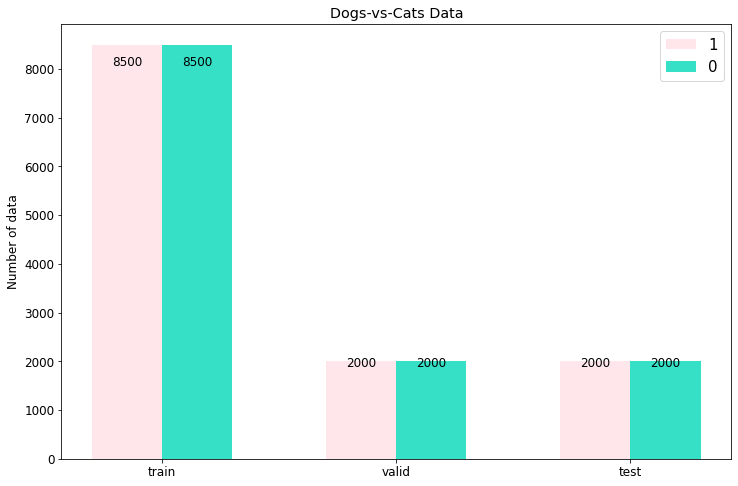

In [0]:
check_images(train_dir, validation_dir, test_dir)

##Hyperparameter initialization and dataset, load configuration

In [0]:
batch_size = 20
epochs = 250
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [0]:
train_image_generator = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

test_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 17000 images belonging to 2 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 4000 images belonging to 2 classes.


In [0]:
test_dir = pathlib.Path(test_dir)

CLASS_NAMES = np.array([item.name for item in test_dir.glob('*') if item.name != "LICENSE.txt"])

In [0]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              classes=list(CLASS_NAMES))

Found 4000 images belonging to 2 classes.


##Model design, detailed configuration of model-related parameters(optimization, loss function, metrics, etc.)

In [0]:
input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input')

def vgg16_model(input_data):
  x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input_data)
  x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)
 
  x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2,2))(x)

  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dense(1, activation='sigmoid')(x)

  return Model(input_data, x)

In [0]:
vgg16 = vgg16_model(input_tensor)

In [0]:
optimizer = optimizers.SGD(lr=0.001, momentum=0.9)

vgg16.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584

##Model learning (with parameters such as checkpoints, steps, epochs, data, etc.)

In [0]:
# #체크포인트 설정
# checkpoint_path = "/content/gdrive/My Drive/dataset/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     checkpoint_path, verbose=1, svae_weights_only=True,
#     period=30)

# vgg16.save_weights(checkpoint_path.format(epoch=0))
history = vgg16.fit_generator(
    train_data_gen,
    steps_per_epoch = 80,
    epochs=epochs,
    validation_data = val_data_gen,
    validation_steps = 20
    # callbacks = [cp_callback]
)

In [0]:
with open('/content/gdrive/My Drive/github_modelNet/all_vgg_16_history.bin', 'wb') as hi:
    pickle.dump(history.history, hi)

##View model learning graphs (250 epochs)

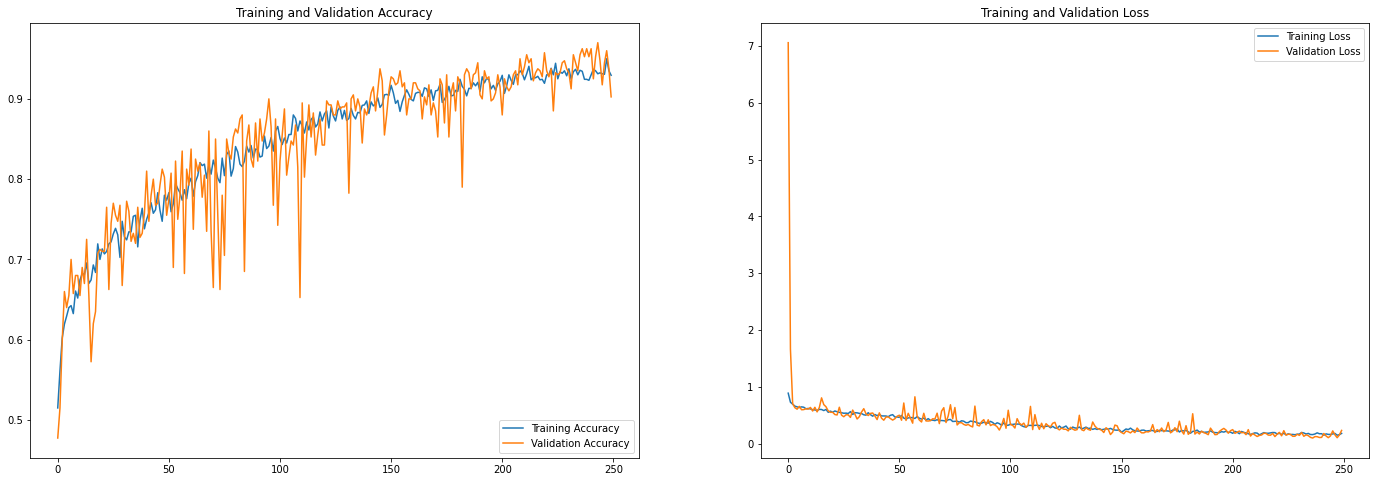

In [0]:
#200 epoch commit graph(train, validation - accracy, loss value)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Assess learning model and confirm prediction

In [0]:
#250 epoch train_step 80, val_step 20 결과
print("Evaluate")
scores = vgg16.evaluate_generator(test_data_gen, steps=200, verbose=1)
print("%s: %.2f%%" %(vgg16.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" %(vgg16.metrics_names[0], scores[0]*100))

Evaluate
200/200 [==============================] - 38s 191ms/step - loss: 0.1351 - accuracy: 0.9505
accuracy: 95.05%
loss: 13.51%


In [0]:
print("Predict")
pred = vgg16.predict_generator(test_data_gen, steps=200, verbose=1)

Predict
200/200 [==============================] - 871s 4s/step


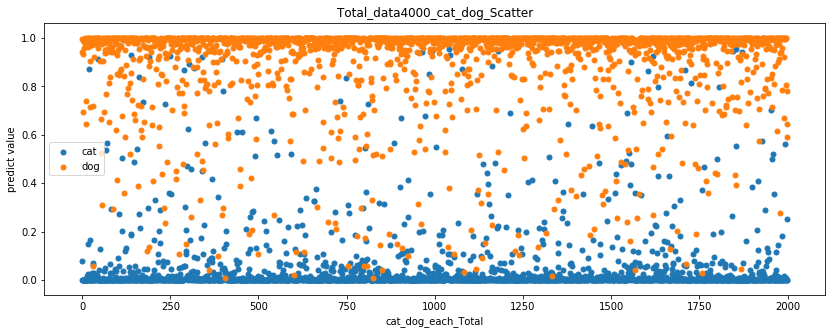

In [0]:
#test predict 예측값 분포도(4000개) - epoch 250(acc 90.20%)

plt.figure(figsize=(14, 5))
plt.title('Total_data4000_cat_dog_Scatter')
plt.xlabel('cat_dog_each_Total')
plt.ylabel('predict value')
plt.scatter(range(2000), pred[:2000], s=25, label = 'cat') #고양이
plt.scatter(range(2000), pred[2000:], s= 25, label = 'dog') #개
plt.legend()
plt.show()

In [0]:
#분류 작업

predict_data = []

for i in range(len(pred)):
  if pred[i] > 0.500:
    predict_data.append(1)
  else:
    predict_data.append(0)

Confusion Matrix


Text(33.0, 0.5, 'true value')

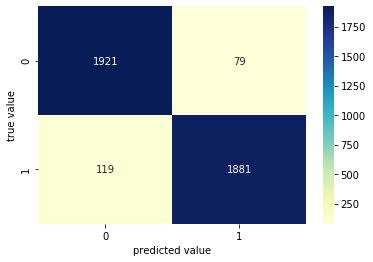

In [0]:
#confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
print("Confusion Matrix")
conf_matrix = confusion_matrix(test_data_gen.classes, predict_data)
#print(conf_matrix)
sns.heatmap(conf_matrix, cmap="YlGnBu", annot=True, fmt='g')
plt.xlabel("predicted value")
plt.ylabel("true value")

##Feature map (one layer or one layer each).

(1, 224, 224, 3)


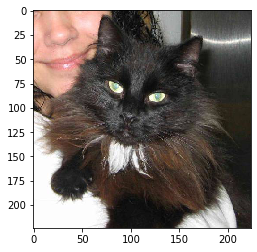

In [0]:
#feature map 

test_image = Image.open('/content/gdrive/My Drive/dataset/test/cat/cat.89.jpg').resize((224, 224))

img_tensor = image.img_to_array(test_image)
img_tensor = np.expand_dims(img_tensor, axis=0)
test_data = img_tensor / 255.0

plt.imshow(test_image)

print(test_data.shape)

In [0]:
#모델 예측 확인

pred_test = vgg16.predict(test_data)

pred_test

array([[0.00028787]], dtype=float32)

In [0]:
feature_model = Sequential()

In [0]:
def Layer_predict(model, image):
  output_layers = [layer.output for layer in model.layers[1:24] if 'batch' != '{}'.format(layer.name[0:5])]
  output_names = [layer.name for layer in model.layers[1:24] if 'batch' != '{}'.format(layer.name[0:5])]

  show_model = tf.keras.models.Model(inputs = model.input, outputs = output_layers)
  # 예측_A
  show_model_pred = show_model.predict(image)
  #print(model_A_pred[0])
  for pred_layer in show_model_pred:
    print(pred_layer.shape)
  return show_model_pred, output_names

In [0]:
layer_outputs, layer_names = Layer_predict(vgg16, test_data)

(1, 224, 224, 64)
(1, 224, 224, 64)
(1, 112, 112, 64)
(1, 112, 112, 128)
(1, 112, 112, 128)
(1, 56, 56, 128)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 56, 56, 256)
(1, 28, 28, 256)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 28, 28, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 14, 14, 512)
(1, 7, 7, 512)


In [0]:
def show_predict_image(show_model_pred,output_names):
    n_col= 16
    _, size2, size, n_features = show_model_pred.shape
    n_row = n_features //n_col
    # feature_map_image = np.zeros(shape=(size2*n_row,size*n_col),dtype=('uint8'))
    feature_map_image = np.zeros(shape=(size2,size*n_col),dtype=('uint8'))
    
    for row in range(1):
        for col in range(n_col):   
            input_fmi = show_model_pred[0,:,:,row*n_col+col]

            input_fmi -= input_fmi.mean()
            input_fmi /= input_fmi.std()
            input_fmi *= 64
            input_fmi += 128
            input_fmi = np.clip(input_fmi, 0, 255).astype('uint8')

            feature_map_image[row*size2:(row+1)*size2, col*size:(col+1)*size] = input_fmi

    plt.figure(figsize=(n_col, n_row))
    plt.xticks([])
    plt.yticks([])
    plt.title('layer : {}'.format(output_names))
    plt.tight_layout()
    plt.imshow(feature_map_image,cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


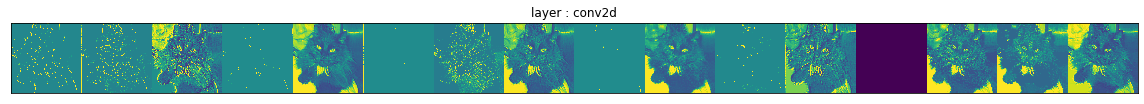

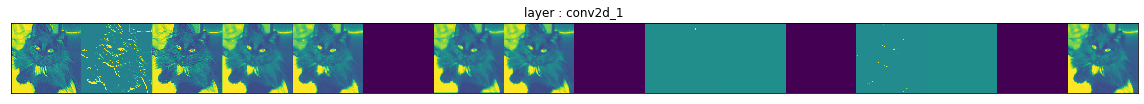

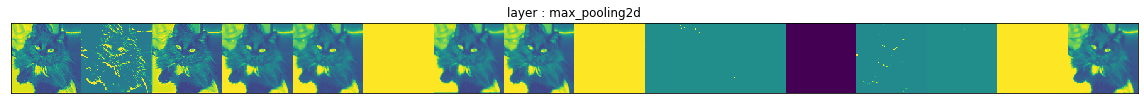

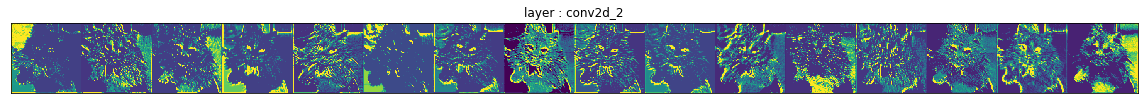

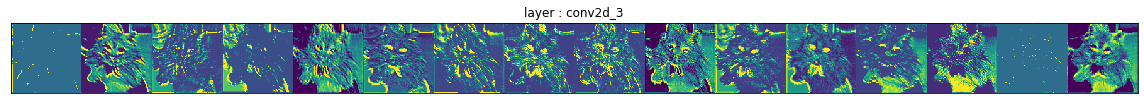

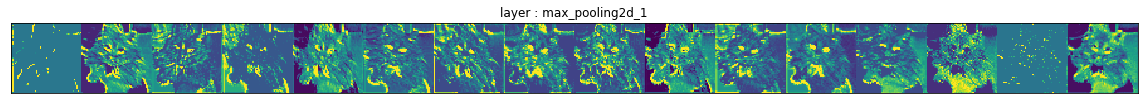

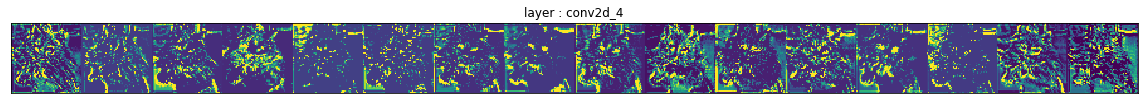

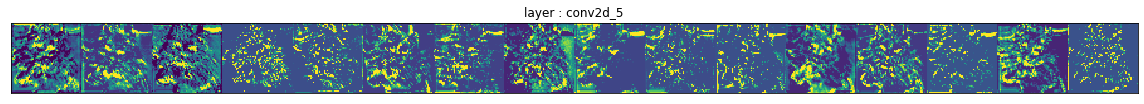

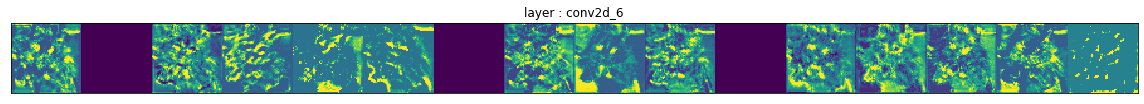

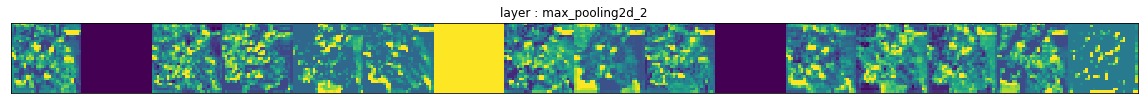

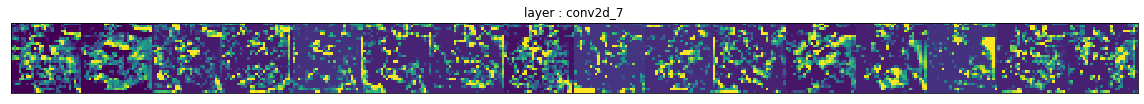

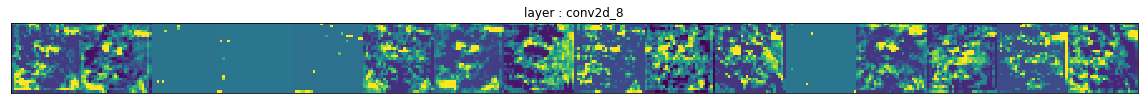

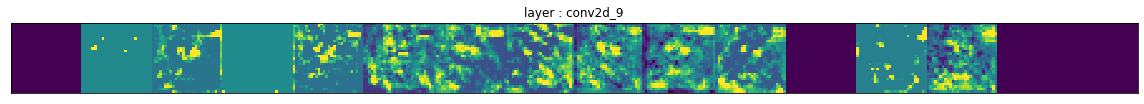

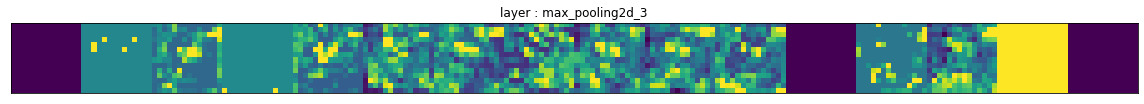

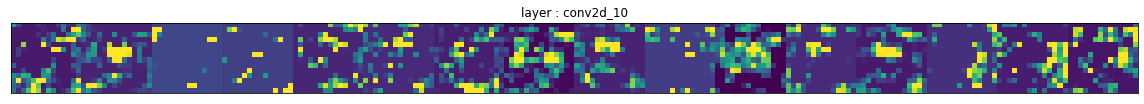

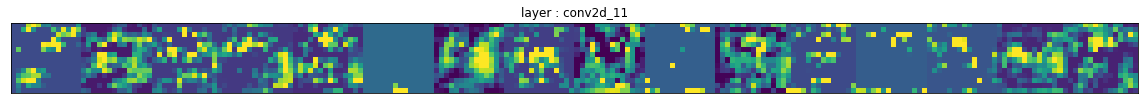

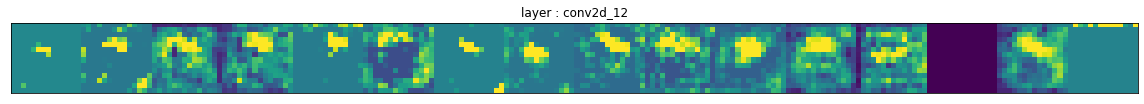

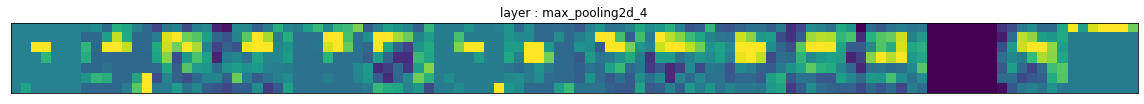

In [0]:
for layer, name in zip(layer_outputs, layer_names):
  show_predict_image(layer, name)
plt.tight_layout()
plt.show()

In [0]:
#각 층의 1개의 피쳐 맵 가져오기
def show_activation_maps(layer, title, i, n_cols=16):
  plt.subplot(2, 9, i+1)
  plt.title('{}:{}'.format(i, title))
  plt.axis('off')
  plt.matshow(layer[0, :, :, i], fignum=0)

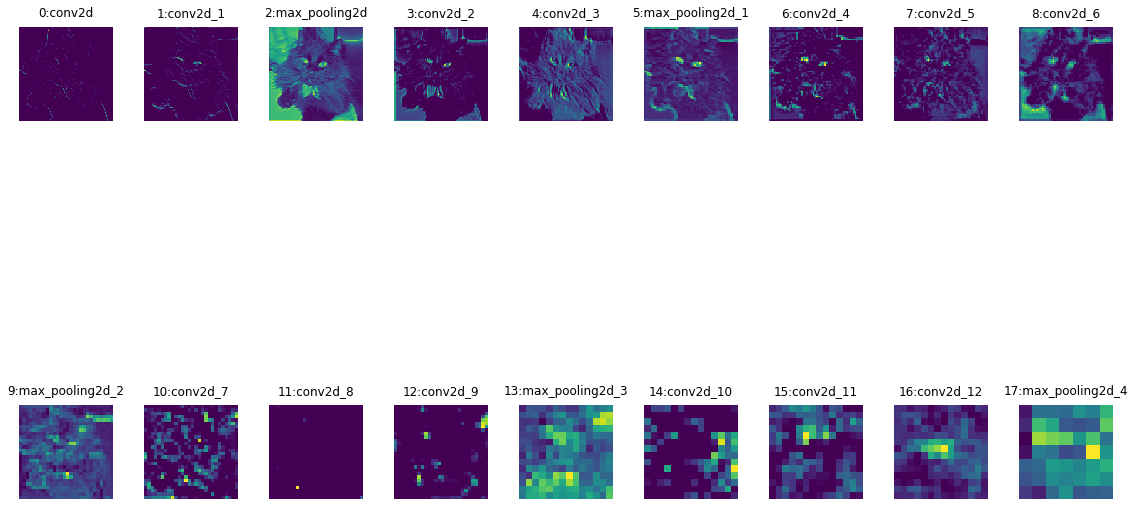

In [0]:
plt.figure(figsize=(16, 14))
for i, (layer, name) in enumerate(zip(layer_outputs, layer_names)):
  
  show_activation_maps(layer, name, i)
plt.tight_layout()
plt.show()

## Grad CAM(cat, dog)

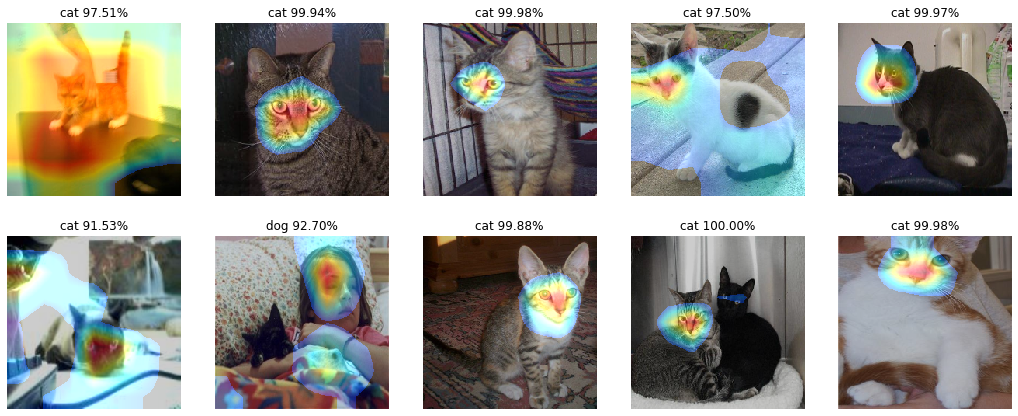

In [0]:
plt.figure(figsize=(18, 15))
for i in range(10):
  try:
    path = os.path.join('/content/gdrive/My Drive/dataset/test/cat/cat.%d.jpg'%i)
    image = cv2.imread(path)
    img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    #print(img.shape)  
  except Exception as e:
    print(str(e))

  x = img.copy()
  x.astype(np.float32)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0
  
  grad_model = tf.keras.models.Model(
        [vgg16.inputs], [vgg16.get_layer(index=23).output, vgg16.output]
    )
    
  with tf.GradientTape() as tape:
      inputs = tf.cast(x, tf.float32)
      model_outputs, predictions = grad_model(inputs)
      loss = predictions[:,0]

  grads = tape.gradient(loss, model_outputs)

  guided_grads = (
        tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
  )

  prediction = predictions[0]
  model_outputs = model_outputs[0]
  plt.subplot(4, 5, i+1)
  if prediction < 0.5:
    plt.title('cat %.2f%%' % (100 - prediction*100))
  else:
    plt.title('dog %.2f%%' % (prediction*100))

  weights = np.mean(grads, axis=(1, 2))
  weights = weights.reshape(512, 1)

  cam = (prediction -0.5) * np.matmul(model_outputs, weights)
  cam -= np.min(cam)
  cam /= np.max(cam)
  cam -= 0.2
  cam /= 0.8

  try:
    cam = cv2.resize(np.float32(cam), (224, 224))
  except Exception as e:
    #print(cam.shape)
    print(str(e))

  heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  heatmap[np.where(cam <= 0.2)] = 0
  grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
  plt.axis('off')
  plt.imshow(grad_cam[:, :, ::-1])

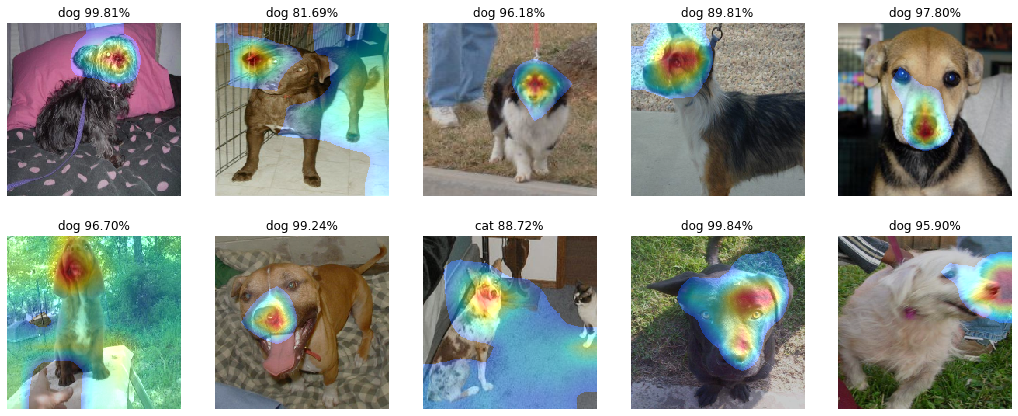

In [0]:
plt.figure(figsize=(18, 15))
for i in range(10):
  try:
    path = os.path.join('/content/gdrive/My Drive/dataset/test/dog/dog.%d.jpg'%i)
    image = cv2.imread(path)
    img = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    #print(img.shape)  
  except Exception as e:
    print(str(e))

  x = img.copy()
  x.astype(np.float32)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0
  
  grad_model = tf.keras.models.Model(
        [vgg16.inputs], [vgg16.get_layer(index=23).output, vgg16.output]
    )
    
  with tf.GradientTape() as tape:
      inputs = tf.cast(x, tf.float32)
      model_outputs, predictions = grad_model(inputs)
      loss = predictions[:,0]

  grads = tape.gradient(loss, model_outputs)

  guided_grads = (
        tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
  )

  prediction = predictions[0]
  model_outputs = model_outputs[0]
  plt.subplot(4, 5, i+1)
  if prediction < 0.5:
    plt.title('cat %.2f%%' % (100 - prediction*100))
  else:
    plt.title('dog %.2f%%' % (prediction*100))

  weights = np.mean(grads, axis=(1, 2))
  weights = weights.reshape(512, 1)

  cam = (prediction -0.5) * np.matmul(model_outputs, weights)
  cam -= np.min(cam)
  cam /= np.max(cam)
  cam -= 0.2
  cam /= 0.8

  try:
    cam = cv2.resize(np.float32(cam), (224, 224))
  except Exception as e:
    #print(cam.shape)
    print(str(e))

  heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
  heatmap[np.where(cam <= 0.2)] = 0
  grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
  plt.axis('off')
  plt.imshow(grad_cam[:, :, ::-1])